# Generating and plotting reconstructions using pyGPlates and cartopy

## Import necessary modules

This code utilizes a Python 3.8 environment with the packages that are found within the paleogeo.yml file in this repository.

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
from shapely.geometry.polygon import Polygon
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

%config InlineBackend.figure_format = 'retina'

The implementation of this analysis relies heavily on functions within pygplates http://www.gplates.org/docs/pygplates/index.html which can be downloaded here: https://sourceforge.net/projects/gplates/. The installation of pygplates requires downloading the package adding it to the PYTHONPATH in .bash_profile. To do this, you need to open the .bash_profile file in a text editor and add this line (changing the path to match the path of pygplates for you):

```export PYTHONPATH=$PYTHONPATH:/Applications/pygplates_rev28_python38_MacOS64```

In [2]:
import pygplates

## Define our own functions

In [3]:
def plot_reconstructed_features(ax, reconstructed_feature, **kwargs):
    """
    Plot reconstructed features output by pygplates.
    Parameters
    ----------
    ax : axis handle
        axis set up by cartopy on which to plot
    reconstructed_feature : reconstructed features
        reconstructed features output by pygplates
    Other Parameters
    ----------------
    **kwargs passed to plt.add_geometries
    Returns
    -------
    None.
    """
    for n in range(len(reconstructed_feature)):

        # pull out lat/lon vertices
        lat_lon_array = reconstructed_feature[n].get_reconstructed_geometry().to_lat_lon_array()
        lats = lat_lon_array[:,0]
        lons = lat_lon_array[:,1]

        # polygons need to be drawn counter clockwise to be drawn properly if they cross the dateline
        if reconstructed_feature[n].get_reconstructed_geometry().get_orientation() == pygplates.PolygonOnSphere.Orientation.clockwise:
            lats = np.flip(lats)
            lons = np.flip(lons)

        # create the polygon and add it to the axis
        # note that ccrs.Geodetic() must be used to make sure that polygons that cross the dateline are drawn properly
        poly = Polygon(zip(lons,lats))
        ax.add_geometries([poly], ccrs.PlateCarree(), **kwargs)

        
def plot_reconstructed_points(ax, reconstructed_feature, **kwargs):
    """
    Plot reconstructed points output by pygplates.
    Parameters
    ----------
    ax : axis handle
        axis set up by cartopy on which to plot
    reconstructed_feature : reconstructed features
        reconstructed features output by pygplates
    Other Parameters
    ----------------
    **kwargs passed to plt.add_geometries
    Returns
    -------
    None.
    """
    for n in range(len(reconstructed_feature)):

        # pull out lat/lon vertices
        lat_lon_array = reconstructed_feature[n].get_reconstructed_geometry().to_lat_lon_array()
        lats = lat_lon_array[:,0]
        lons = lat_lon_array[:,1]

        ax.scatter(lons, lats, transform=ccrs.PlateCarree(), **kwargs)

## Read In Files

The following code imports the following files:
- CEED_blocks : continental polygon blocks from the CEED6 model used in Torsvik and Cocks, (2017) with the addition of the Domeier (2018) Kazakh polygons
- Matthews_blocks : continental polygon blocks from the Matthews et al. (2016) model
- TC17_SHM17_D18_model : modified Torsvik and Cocks (2017) model that is modified by: 1) implementing the Swanson-Hysell and Macdonald (2017) Ordovician modification for Laurentia based on high-quality paleomagnetic data from allochthonous terranes and 2) adjustments of the early Paleozoic paleogeography of Asia made by Domeier (2018). These adjustments include the addition of ‘North Tianshan’ and ‘Boshekul-Chingiz’ zone rotation parameters so that sutures in the Kazakh terranes can be reconstructed as well as adjustments for North China, South China, Siberia and Tarim.
- M2016_model : rotation file for the Matthews et al. (2016) model (0 to 250 Ma)

In [4]:
CEED_blocks = pygplates.FeatureCollection.read('paleogeo_models/CEED6+Kazakh/CEED6+D18_Kazakh.shp')
CEED_land = pygplates.FeatureCollection.read('paleogeo_models/CEED6/CEED6_LAND.shp')
Matthews_blocks = pygplates.FeatureCollection.read('paleogeo_models/Matthews_etal_2016_Global_Plate_Model_GPC/ContPolys/PresentDay_ContinentalPolygons_Matthews++.shp')

TC17_SHM17_D18_model = 'paleogeo_models/TC2017_SHM2017_D2018.rot'
M2016_model = 'paleogeo_models/Matthews_etal_2016_Global_Plate_Model_GPC/Global_EB_250-0Ma_GK07_Matthews++.rot'

## Make a reconstruction at a single time

The code below makes a reconstruction of the CEED (Centre for Earth Evolution and Dynamics) blocks using the TC17_SHM17_D18_model at a single time slice. Note that setting the anchor plate is crucial. The default anchor_plate_ID of 0 is not the spin axis, but is the mantle reference frame. Using 0 instead of 1 as the anchor plate ID will result in reconstruction that is not appropriate for interpretting paleolatitude.



NameError: name 'plot_reconstructed_feature' is not defined

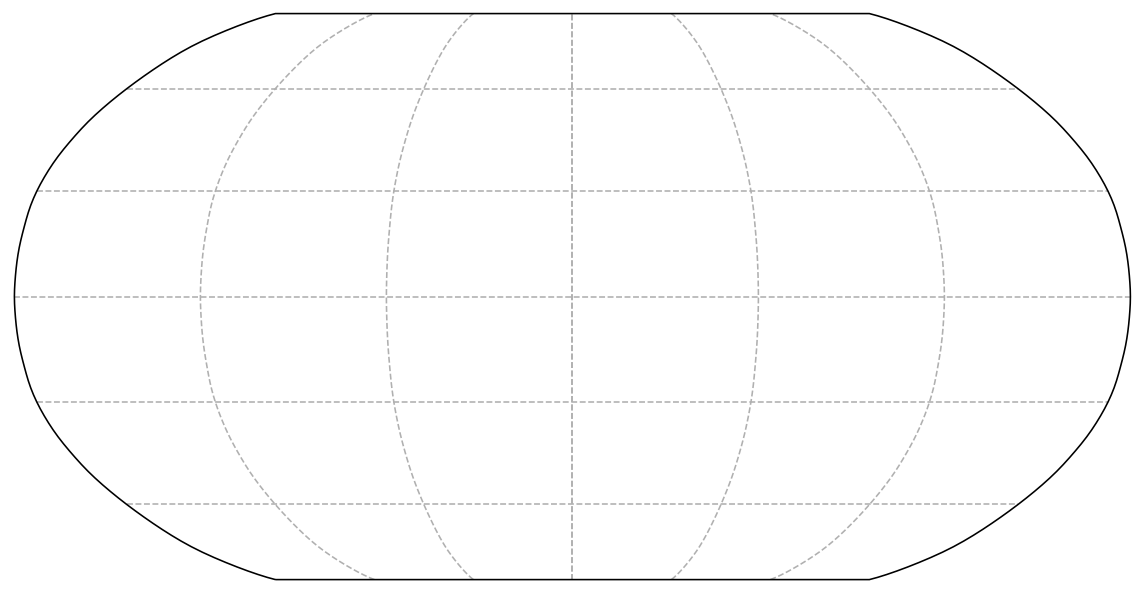

In [5]:
t = 500     #reconstruction time
anchor = 1  #anchor plate ID (1 : spin axis)

CEED_blocks_recon = []
pygplates.reconstruct(CEED_blocks, TC17_SHM17_D18_model, CEED_blocks_recon, t, anchor)

CEED_land_recon = []
pygplates.reconstruct(CEED_land, TC17_SHM17_D18_model, CEED_land_recon, t, anchor)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
ax.set_global()
ax.gridlines(xlocs=np.arange(-180,181,60),ylocs=np.arange(-90,91,30),linestyle='--')

plot_reconstructed_feature(ax,CEED_land_recon,color='#D7DBDD',linewidth=0.5)
plot_reconstructed_feature(ax,CEED_blocks_recon,color='#909497')
plt.title(str(t) + ' Ma reconstruction')

plt.show()

### Plot on a different projection

Now that the blocks are reconstructed, we can plot them on different cartopy projections by changing the ccrs.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=180)))
ax.set_global()
ax.gridlines(xlocs=np.arange(-180,181,60),ylocs=np.arange(-90,91,30),linestyle='--')

plot_reconstructed_feature(ax,CEED_land_recon,color='#D7DBDD',linewidth=0.5)
plot_reconstructed_feature(ax,CEED_blocks_recon,color='#909497')
plt.title(str(t) + ' Ma reconstruction')

plt.show()

## Plot points

Let's start by generating a list of points and plotting their modern day positions. The format of the list will be (lat,long,plateid) for each point.

In [ ]:
archaeo_points = []
archaeo_points.append((51.470708,-56.837839,101)) #101 is Laurentia
archaeo_points.append((37.431205,-117.458648,153)) #153 Roberts Mountains Allochthon
archaeo_points.append((61.526316,-132.313917,162)) #162 is Laurentia Parautochthon

In [ ]:
archaeo_lats = np.array(archaeo_points)[:,0].tolist()
archaeo_lons = np.array(archaeo_points)[:,1].tolist()

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=250,central_latitude=30)))
ax.stock_img()
shape_feature = ShapelyFeature(Reader('paleogeo_models/CEED6+Kazakh/CEED6+D18_Kazakh.shp').geometries(),
                                ccrs.PlateCarree(), edgecolor='black',facecolor='none')
ax.add_feature(shape_feature)
ax.scatter(archaeo_lons,archaeo_lats,transform=ccrs.PlateCarree(),c='tomato',s=200,zorder=1000,marker='*')
plt.show()

These points then need to be reconstructed using the paleogeographic model rotation file.

In [ ]:
archaeo_features = []
for lat, lon, plate_id in archaeo_points:
    archaeo_feature = pygplates.Feature()
    archaeo_feature.set_geometry(pygplates.PointOnSphere(lat, lon))
    archaeo_feature.set_reconstruction_plate_id(plate_id)
    archaeo_features.append(archaeo_feature)
    
# Reconstruct the point features.
archaeo_reconstructed = []
pygplates.reconstruct(archaeo_features, TC17_SHM17_D18_model, 
                      archaeo_reconstructed, t, anchor)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=180)))
ax.set_global()
ax.gridlines(xlocs=np.arange(-180,181,60),ylocs=np.arange(-90,91,30),linestyle='--')

plot_reconstructed_feature(ax,CEED_land_recon,color='#D7DBDD',linewidth=0.5)
plot_reconstructed_feature(ax,CEED_blocks_recon,color='#909497')
plot_reconstructed_points(ax,archaeo_reconstructed,color='tomato',marker='*',s=100,zorder=100)
plt.title(str(t) + ' Ma reconstruction')

plt.show()

## Generate multiple reconstructions

Here we iterate through a time list generating and saving reconstructions at each time.

In [ ]:
time_list = [525,520,515,510,505,500]
anchor = 1

for time in time_list:
    t = time
    CEED_blocks_recon = []
    pygplates.reconstruct(CEED_blocks, TC17_SHM17_D18_model, CEED_blocks_recon, t, anchor)

    CEED_land_recon = []
    pygplates.reconstruct(CEED_land, TC17_SHM17_D18_model, CEED_land_recon, t, anchor)
    
    archaeo_reconstructed = []
    pygplates.reconstruct(archaeo_features, TC17_SHM17_D18_model, 
                      archaeo_reconstructed, t, anchor)

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.Orthographic(central_longitude=200)))
    ax.set_global()
    ax.gridlines(xlocs=np.arange(-180,181,60),ylocs=np.arange(-90,91,30),linestyle='--')

    plot_reconstructed_feature(ax,CEED_land_recon,color='#D7DBDD',linewidth=0.5)
    plot_reconstructed_feature(ax,CEED_blocks_recon,color='#909497')
    plot_reconstructed_points(ax,archaeo_reconstructed,color='tomato',marker='*',s=100,zorder=100)
    plt.title(str(t) + ' Ma reconstruction')
    
    file_name = 'code_output/Laurentia_' + str(t) + '.eps'

    plt.savefig(file_name)
    plt.show()